In [10]:
import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def load_data(filename):
    data = loadmat(filename)
    return data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']

def cost(theta, X, y, Lambda):
    m = np.shape(X)[0]
    theta = theta.reshape(-1, y.shape[1])
    unreg_term = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    reg_term = (Lambda / (2 * m)) * np.sum(np.square(theta[1:len(theta)]))
    return unreg_term + reg_term

def grad(theta, X, y, Lambda):
    m = np.shape(X)[0]
    theta = theta.reshape(-1, y.shape[1])
    grad = np.zeros(theta.shape)
    grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y) + (Lambda / m ) * theta
    unreg_grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y)
    grad[0] = unreg_grad[0]
    return grad.flatten()

def linear_reg_cost(Theta, X, Y, Lambda):
    return cost(Theta, X, Y, Lambda), grad(Theta, X, Y, Lambda)

def linear_reg_train(X, y, Lambda):
    theta = np.zeros([X.shape[1], 1])
    def cost_func(Theta):
        return linear_reg_cost(Theta, X, y, Lambda)
    result = opt.minimize(fun=cost_func, x0=theta, method='CG', jac=True, options={'maxiter':200})
    return result.x

def learning_curve(X, y, Xval, yval, Lambda):
    m = X.shape[0]
    error_train = np.zeros([m, 1])
    error_val = np.zeros([m, 1])
    for i in range(1, m + 1):
        theta = linear_reg_train(X[:i], y[:i], Lambda)
        error_train[i - 1] = linear_reg_cost(theta, X[:i], y[:i], 0)[0]
        error_val[i - 1] = linear_reg_cost(theta, Xval, yval, 0)[0]
    return error_train, error_val

def poly_feature(X, p):
    X_poly = X
    for i in range(1, p):
        X_poly = np.column_stack((X_poly, np.power(X, i + 1)))
    return X_poly

def normalize_feature(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    return X_norm, mu, sigma

def plot_fit(min_x, max_x, mu, sigma, theta, p):
    x = np.array(np.arange(min_x - 15, max_x + 25, 0.05))
    X_poly = poly_feature(x, p)
    X_poly = X_poly - mu
    X_poly = X_poly / sigma
    X_poly = np.insert(X_poly, 0, 1, axis=1)
    plt.plot(x, np.dot(X_poly, theta), '--')

def validation_curve(X, y, Xval, yval):
    lambdas = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train = np.zeros((len(lambdas), 1))
    error_val = np.zeros((len(lambdas), 1))
    for i in range(len(lambdas)):
        Lambda = lambdas[i]
        theta = linear_reg_train(X, y, Lambda)
        error_train[i] = linear_reg_cost(theta, X, y, 0)[0]
        error_val[i] = linear_reg_cost(theta, Xval, yval, 0)[0]         
    return lambdas, error_train, error_val


def test_one():
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    print("Shapes of X{} and y{}".format(X.shape, y.shape))
    print("Shapes of Xval{} and yval{}".format(Xval.shape, yval.shape))
    print("Shapes of Xtest{} and ytest{}".format(Xtest.shape, ytest.shape))
    plt.figure(figsize=(8, 6))
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Figure 1: Data')
    plt.plot(X, y, 'rx')
    plt.show()

def test_two():
    Lambda = 1.0
    theta = np.array([[1], [1]])
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    X_ones = np.hstack([np.ones([np.shape(X)[0], 1]), X])
    cost, grad = linear_reg_cost(theta, X_ones, y, Lambda)
    print('Cost and Gradient at theta = [1, 1]:', cost, grad)

def test_three():
    Lambda = 0.0
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    X_ones = np.hstack([np.ones([np.shape(X)[0], 1]), X])
    theta = linear_reg_train(X_ones, y, Lambda)
    print('Theta: ', theta)
    plt.figure(figsize=(8, 6))
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Figure 2: Linear Fit')
    plt.plot(X, y, 'rx')
    plt.plot(X, np.dot(np.insert(X, 0, 1, axis=1), theta), '--')
    plt.show()

def test_four():
    Lambda = 0.0
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]
    X_ones = np.hstack([np.ones([m, 1]), X])
    Xval_ones = np.hstack([np.ones([Xval.shape[0], 1]), Xval])
    error_train, error_val = learning_curve(X_ones, y, Xval_ones, yval, Lambda)

    print('# Training Examples\tTrain Error\tCross Validation Error\n')
    for i in range(m):
        print('{}\t\t\t{:f}\t{:f}\n'.format(i + 1, float(error_train[i]), float(error_val[i])))

    plt.figure(figsize=(8, 6))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 3: Linear regression learning curve')
    plt.plot(range(1, m + 1), error_train, 'b', label='Train')
    plt.plot(range(1, m + 1), error_val, 'g', label='Cross Validation')
    plt.legend()
    plt.show()

def test_five():
    p = 8
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]

    # Map X onto Polynomial Features and Normalize.
    X_poly = poly_feature(X, p)
    X_poly, mu, sigma = normalize_feature(X_poly) # Normalize
    X_poly = np.insert(X_poly, 0, 1, axis=1) # Add Ones

    # Map X_poly_test and normalize (using mu and sigma).
    X_poly_test = poly_feature(Xtest, p)
    X_poly_test = X_poly_test - mu
    X_poly_test = X_poly_test / sigma
    X_poly_test = np.insert(X_poly_test, 0, 1, axis=1) # Add Ones

    # Map X_poly_val and normalize (using mu and sigma).
    X_poly_val = poly_feature(Xval, p)
    X_poly_val = X_poly_val - mu
    X_poly_val = X_poly_val / sigma
    X_poly_val = np.insert(X_poly_val, 0, 1, axis=1) # Add Ones

    print('Normalized Training Example 1:')
    print(X_poly[1, :])

    # Train linear regression with lambda_coef = 0.
    theta = linear_reg_train(X_poly, y, 0)

    plt.figure(figsize=(8, 6))
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Figure 4: Polynomial fit, $\lambda$ = 0')
    plt.plot(X, y, 'rx')
    plot_fit(min(X), max(X), mu, sigma, theta, p)
    plt.show()

    # Get the errors with lambda_coef set to 0.
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, 0)

    plt.figure(figsize=(8, 6))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 5: Polynomial learning curve, $\lambda$ = 0')
    plt.plot(range(1,m+1), error_train, 'b', label='Train')
    plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
    plt.legend()
    plt.show()

    # Train linear regression with lambda_coef = 100.
    theta = linear_reg_train(X_poly, y, 100)

    plt.figure(figsize=(8, 6))
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Figure 4: Polynomial fit, $\lambda$ = 100')
    plt.plot(X, y, 'rx')
    plot_fit(min(X), max(X), mu, sigma, theta, p)
    plt.show()

    # Get the errors with lambda_coef set to 100.
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, 100)

    plt.figure(figsize=(8, 6))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 5: Polynomial learning curve, $\lambda$ = 100')
    plt.plot(range(1,m+1), error_train, 'b', label='Train')
    plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation')
    plt.legend()
    plt.show()

def test_six():
    p = 8
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]

    # Map X onto Polynomial Features and Normalize.
    X_poly = poly_feature(X, p)
    X_poly, mu, sigma = normalize_feature(X_poly) # Normalize
    X_poly = np.insert(X_poly, 0, 1, axis=1) # Add Ones

    # Map X_poly_test and normalize (using mu and sigma).
    X_poly_test = poly_feature(Xtest, p)
    X_poly_test = X_poly_test - mu
    X_poly_test = X_poly_test / sigma
    X_poly_test = np.insert(X_poly_test, 0, 1, axis=1) # Add Ones

    # Map X_poly_val and normalize (using mu and sigma).
    X_poly_val = poly_feature(Xval, p)
    X_poly_val = X_poly_val - mu
    X_poly_val = X_poly_val / sigma
    X_poly_val = np.insert(X_poly_val, 0, 1, axis=1) # Add Ones

    print('Normalized Training Example 1:')
    print(X_poly[1, :])

    lambdas, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)

    print('lambda\tTrain Error\tValidation Error\n')
    for i in range(len(lambdas)):
        print('{}\t{}\t{}\n'.format(lambdas[i], error_train[i], error_val[i]))

    plt.figure(figsize=(8, 6))
    plt.xlabel('$\lambda$')
    plt.ylabel('Error')
    plt.title('Figure 10: Selecting $\lambda$ using a cross validation set')
    plt.plot(lambdas, error_train, 'b', label='Train')
    plt.plot(lambdas, error_val, 'g', label='Cross Validation')
    plt.legend()
    plt.show()

    # Train the model with the best value of lambda_coef.
    theta = linear_reg_train(X_poly, y, 3)

    # Get the test error with lambda_coef set to 0!!!
    error_test = linear_reg_cost(theta, X_poly_test, ytest, 0)[0]
    print("Test error for the best lambda: {0:.4f}".format(error_test))

Shapes of X(12, 1) and y(12, 1)
Shapes of Xval(21, 1) and yval(21, 1)
Shapes of Xtest(21, 1) and ytest(21, 1)


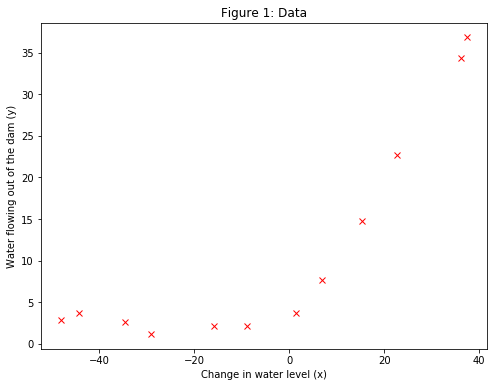

Cost and Gradient at theta = [1, 1]: 303.9931922202643 [-15.30301567 598.25074417]
Theta:  [13.08790351  0.36777923]


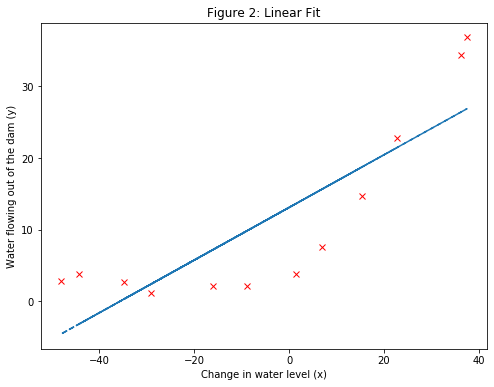

# Training Examples	Train Error	Cross Validation Error

1			0.000000	205.121096

2			0.000000	110.300366

3			3.286595	45.010232

4			2.842678	48.368911

5			13.154049	35.865141

6			19.443963	33.829957

7			20.098522	31.970987

8			18.172859	30.862446

9			22.609405	31.135998

10			23.261462	28.936207

11			24.317250	29.551432

12			22.373906	29.433818



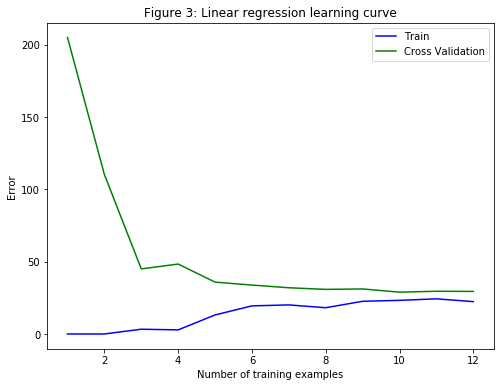

Normalized Training Example 1:
[ 1.         -0.8389201   0.0013142  -0.25896174 -0.34156482  0.09754927
 -0.45519664  0.26677343 -0.46887381]


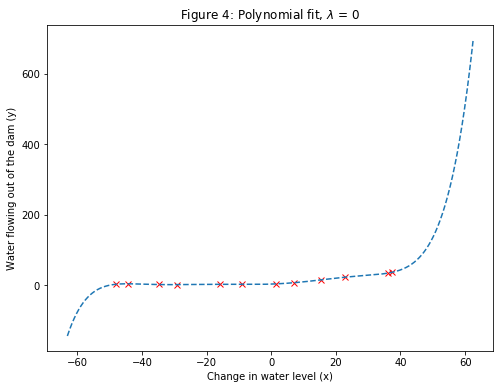

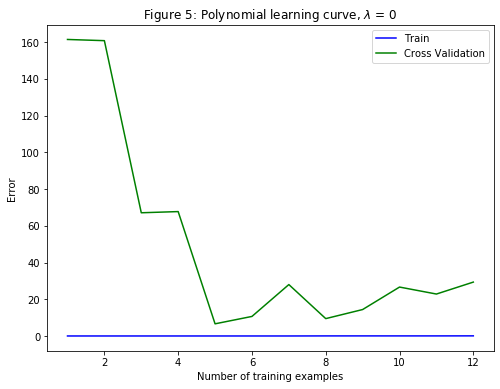

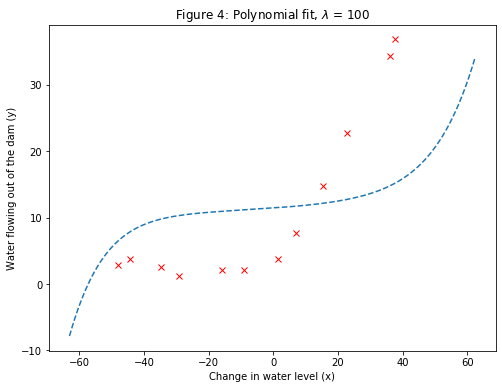

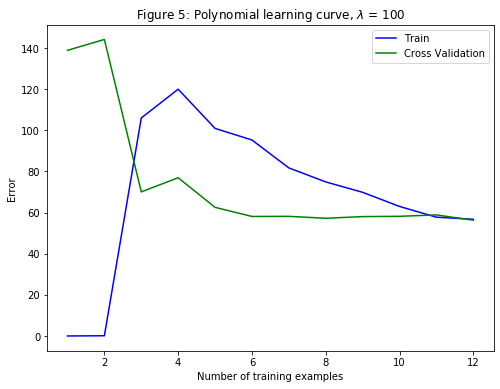

Normalized Training Example 1:
[ 1.         -0.8389201   0.0013142  -0.25896174 -0.34156482  0.09754927
 -0.45519664  0.26677343 -0.46887381]
lambda	Train Error	Validation Error

0.0	[0.06273204]	[29.33427972]

0.001	[0.11971822]	[11.13129507]

0.003	[0.16676012]	[15.93209366]

0.01	[0.21796048]	[17.14794581]

0.03	[0.27515409]	[13.21550243]

0.1	[0.43866184]	[7.9269578]

0.3	[0.86816604]	[4.76080002]

1.0	[1.95869484]	[4.26335869]

3.0	[4.52510481]	[3.83217638]

10.0	[14.82580826]	[8.88972473]



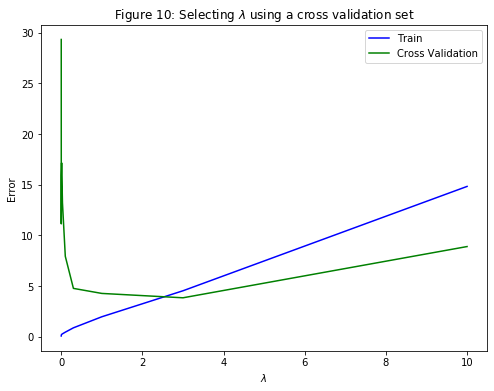

Test error for the best lambda: 3.5720


In [13]:
test_one()
test_two()
test_three()
test_four()
test_five()
test_six()